In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

from scipy.optimize import curve_fit

from astropy import units as u
from astropy import constants as c
from astropy.time import Time

from sunpy.data import cache
from sunpy.coordinates import spice, frames
from sunpy.net import Fido
from sunpy.net.cdaweb import get_datasets
from sunpy.net.cdaweb import get_observatory_groups
from sunpy.time import parse_time
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries

from sw_functions import download_sc_dataset, get_trajectory, bin_distance
from usefulfunc import fit_model, power_law, double_gaussian

/Users/nathan/.pyenv/versions/3.13.7/envs/sun_capstone/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get Mag / SW data
psp_mag, solo_mag = pd.read_pickle('data/psp_mag_rtn_1hour'), pd.read_pickle('data/solo_mag_rtn_1hour')
psp_sw, solo_sw = pd.read_pickle('data/psp_sweap_l3i_1hour'), pd.read_pickle('data/solo_swa_pas_grnd_mom_l2_1hour')

# Compute trajectory data
psp_traj_mag, psp_obstime_mag = get_trajectory(psp_mag, 'psp')
psp_traj_sw, psp_obstime_sw = get_trajectory(psp_sw, 'psp')

solo_traj_mag, solo_obstime_mag = get_trajectory(solo_mag, 'solo')
solo_traj_sw, solo_obstime_sw = get_trajectory(solo_sw, 'solo')

In [3]:
psp = psp_sw.join(psp_mag)
solo = solo_mag.join(solo_sw)

psp['Distance'] = psp_traj_sw.radius.to('AU').value
solo['Distance'] = solo_traj_mag.radius.to('AU').value

In [4]:
# Combine Datasets
joined_mag, joined_sw = pd.concat([psp_mag, solo_mag]), pd.concat([psp_sw, solo_sw])

# Combine Distances
sc_dist_mag, sc_dist_sw = [*psp_traj_mag.radius.to('AU').value, *solo_traj_mag.radius.to('AU').value], [*psp_traj_sw.radius.to('AU').value, *solo_traj_sw.radius.to('AU').value]
joined_dist_mag, joined_dist_sw = pd.DataFrame({'Sun Distance' : sc_dist_mag}), pd.DataFrame({'Sun Distance' : sc_dist_sw})

# MinMax values for mag and sw data
joined_mag_max, joined_mag_min = joined_mag.max(), joined_mag.min()
joined_sw_max, joined_sw_min = joined_sw.max(), joined_sw.min()

In [5]:
def create_ds(sc, year=None, years=None, dist_lim=None):
    """Create PSP or SolO complete dataset, global or by year.
    """
    if sc == 'psp':
        ds = psp_sw.join(psp_mag)
        ds['Distance'] = psp_traj_sw.radius.to('AU').value
        ds['lon'] = psp_traj_sw.lon.to('deg').value
        ds['lat'] = psp_traj_sw.lat.to('deg').value
        # Slice during Solo's Mission duration
        #start, end = '2020-4-15', '2025-5-31'
        #ds = ds[(ds.index >= start) & (ds.index <= end)]

    if sc == 'solo':
        ds = solo_sw.join(solo_mag)
        ds['Distance'] = solo_traj_sw.radius.to('AU').value
        ds['lon'] = solo_traj_sw.lon.to('deg').value
        ds['lat'] = solo_traj_sw.lat.to('deg').value

    if dist_lim:
        dist_min, dist_max = dist_lim
        ds = ds[(ds['Distance'] <= dist_max) & (ds['Distance'] >= dist_min)]

    if year:
        ds = ds[ds.index.year == year]

    if years:
        ds = ds[(ds.index.year >= years[0]) & (ds.index.year <= years[1])]

    return ds

def bin_distance(ds, counts=10):
    """Get SC params median and stdev binned by distance from a dataset.
    """
    # Create bins
    bins = np.arange(0, 1 + 1/counts, 1/counts)
    #bins = np.arange(-0.025, 1 + 1/20, 1/20) # centered on 0.05 AU
    ds['distance_bin'] = pd.cut(ds['Distance'], bins)

    # Group by distance bins and compute median, min, max
    sc_dist_med = ds.groupby('distance_bin', observed=False).median().reset_index()
    sc_dist_std = ds.groupby('distance_bin', observed=False).std().reset_index()

    return sc_dist_med, sc_dist_std

# Power Laws

In [8]:
def plot_power_laws(sc, param, unit=None, year=None, bins=10, subs=100, raw=False):
    # Initialise dataset
    ds = create_ds(sc, year)

    # Create distance bins and bin values in 0.1 AU intervals
    distance_bins = np.arange(0, 1 + 1/bins, 1/bins)
    ds['distance_bin'] = pd.cut(ds['Distance'], distance_bins)

    # Create figure, flatten axes for looping
    fig, ax = plt.subplots(bins//3, 3, figsize=(15,20))
    ax = ax.flatten()

    fit_list = []
    # Plot Fitted power law to median data
    for aa, bin in zip(ax, np.unique(ds['distance_bin'].dropna())):
        # Set xlimits: bounds of current bin
        d_min, d_max = bin.left, bin.right
        aa.set_xlim(d_min, d_max)

        print(f'\n{d_min}-{d_max} AU\n---')

        # Bin data within the distance bin
        sub_ds = ds[ds['distance_bin'] == bin]
        sub_ds['sub_bin'] = pd.cut(ds['Distance'], np.arange(bin.left, bin.right + 1/subs, 1/subs))

        # Take the median of the sub-binned data
        sub_ds_med = sub_ds.groupby('sub_bin', observed=False).median(numeric_only=True).reset_index()
        sub_ds_std = sub_ds.groupby('sub_bin', observed=False).std(numeric_only=True).reset_index()

        # Plot Raw data and sub-binned medians
        aa.plot(sub_ds['Distance'], sub_ds[f'{param}'], '.', c='lightgrey', alpha=.6)
        aa.plot(sub_ds_med['Distance'], sub_ds_med[f'{param}'], '.')

        # Only plot if there is more than 1 data point
        if len(sub_ds_med[f'{param}'].dropna()) > 1:
            # Choose to fit over raw data or medians and plot it
            if raw:
                # Remove Nans
                data = pd.concat([sub_ds['Distance'], sub_ds[f'{param}']], axis=1).dropna()
                x_clean = data.iloc[:, 0].values
                y_clean = data.iloc[:, 1].values
                # Fit curve
                p_fit, e_fit, r_squared, _, res = fit_model(power_law, x_clean, y_clean)
                # Plot
                aa.plot(sub_ds['Distance'], power_law(sub_ds['Distance'], *p_fit), 'r-')
            else:
                # Remove Nans
                data = pd.concat([sub_ds_med['Distance'], sub_ds_med[f'{param}'], sub_ds_std[f'{param}']], axis=1).dropna()
                x_clean = data.iloc[:, 0].values
                y_clean = data.iloc[:, 1].values
                s_clean = data.iloc[:, 2].values

                # Fit curve
                p_fit, e_fit, r_squared, _, res = fit_model(power_law, x_clean, y_clean, s=s_clean)
                # Plot
                aa.plot(sub_ds_med['Distance'], power_law(sub_ds_med['Distance'], *p_fit), 'r-')

                # Append fit data
                fit_row = {'bin_start': d_min, 'bin_end':d_max, 'a': p_fit[0], 'b': p_fit[1], 'a_e': e_fit[0], 'b_e': e_fit[1], 'r_squared': r_squared}
                fit_list.append(fit_row)

                # Add parameter and r squared info on plot
                aa.text(0.65, 0.98, f'{'a':>3} = {p_fit[0]:.2f}±{e_fit[0]:.2f}\n{'b':>3} = {p_fit[1]:.2f}±{e_fit[1]:.2f}\n$R^2$ = {r_squared:.2f}', ha='left', va='top', transform=aa.transAxes)

        # Error bars
        err = aa.errorbar(sub_ds_med['Distance'], sub_ds_med[f'{param}'], yerr=sub_ds_std[f'{param}'], fmt='none', capsize=5)

        # Error bar styling
        for barlinecol in err[2]:
            barlinecol.set_linestyle('--')
            barlinecol.set_linewidth(0.5)
            barlinecol.set_color('black')
        
        # Set axes title and xy labels
        aa.set_title(f'{d_min}-{d_max} AU')
        aa.set_ylabel(f'{param} ({unit})')
        aa.set_xlabel('Distance (AU)')

    # Create data frame
    fit_data = pd.DataFrame(fit_list)

    # Set figure labels
    fig.suptitle(f'Power laws using median of {param} from {sc.upper()} over whole mission range', y=.91)
    return fig, ax, fit_data


0.0-0.1 AU
---

0.1-0.2 AU
---

0.2-0.3 AU
---

0.3-0.4 AU
---

0.4-0.5 AU
---

0.5-0.6 AU
---

0.6-0.7 AU
---

0.7-0.8 AU
---

0.8-0.9 AU
---


/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_98136/2615801971.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_ds['sub_bin'] = pd.cut(ds['Distance'], np.arange(bin.left, bin.right + 1/subs, 1/subs))
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_98136/2615801971.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_ds['sub_bin'] = pd.cut(ds['Distance'], np.arange(bin.left, bin.right + 1/subs, 1/subs))
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_98136/26158


0.2-0.3 AU
---

0.3-0.4 AU
---

0.4-0.5 AU
---

0.5-0.6 AU
---

0.6-0.7 AU
---

0.7-0.8 AU
---

0.8-0.9 AU
---

0.9-1.0 AU
---


/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_98136/2615801971.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_ds['sub_bin'] = pd.cut(ds['Distance'], np.arange(bin.left, bin.right + 1/subs, 1/subs))
/Users/nathan/Documents/Code/sun_capstone/usefulfunc.py:133: OptimizeWarning: Covariance of the parameters could not be estimated
  p_fit, pcov = curve_fit(fit_func, x, y, sigma=s)
/Users/nathan/Documents/Code/sun_capstone/usefulfunc.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  chi2_val = ss_res / (x.size - len(p_fit))
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_98136/2615801971.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

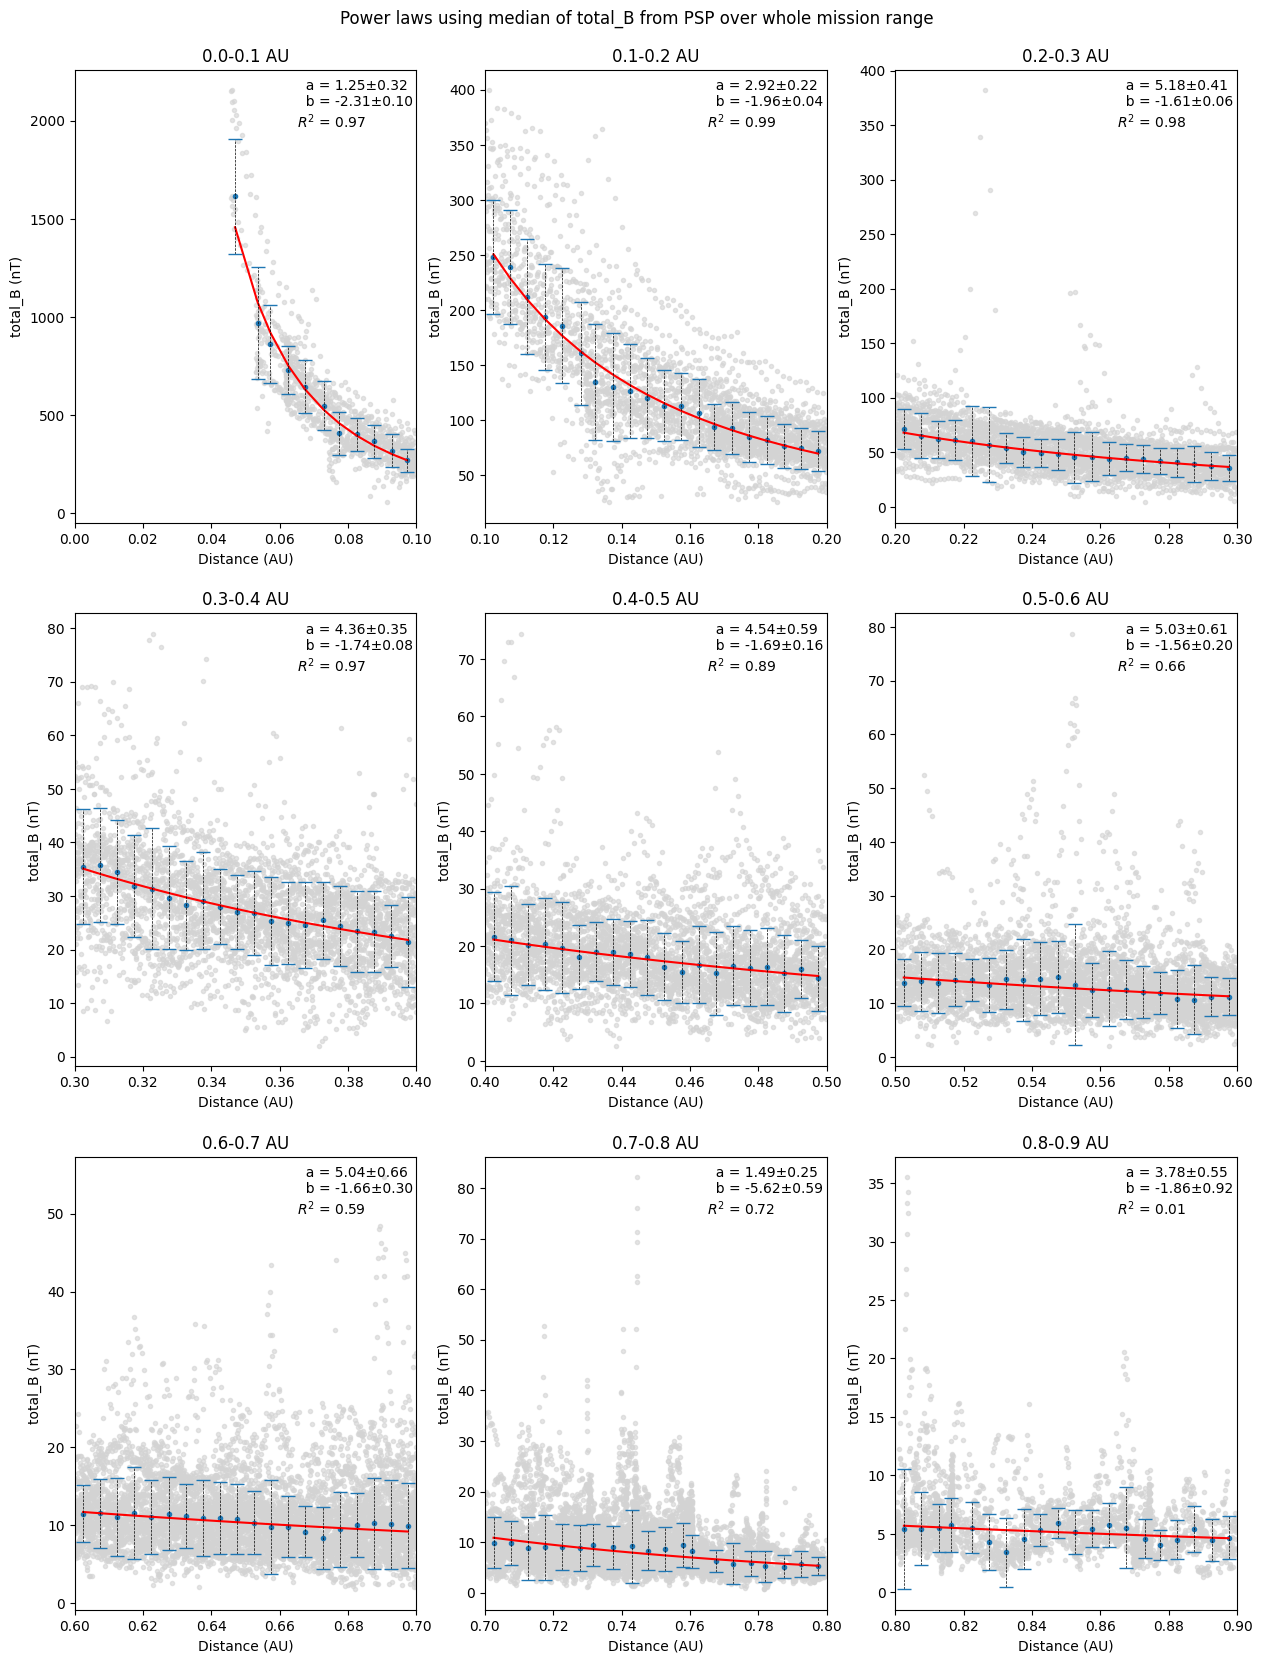

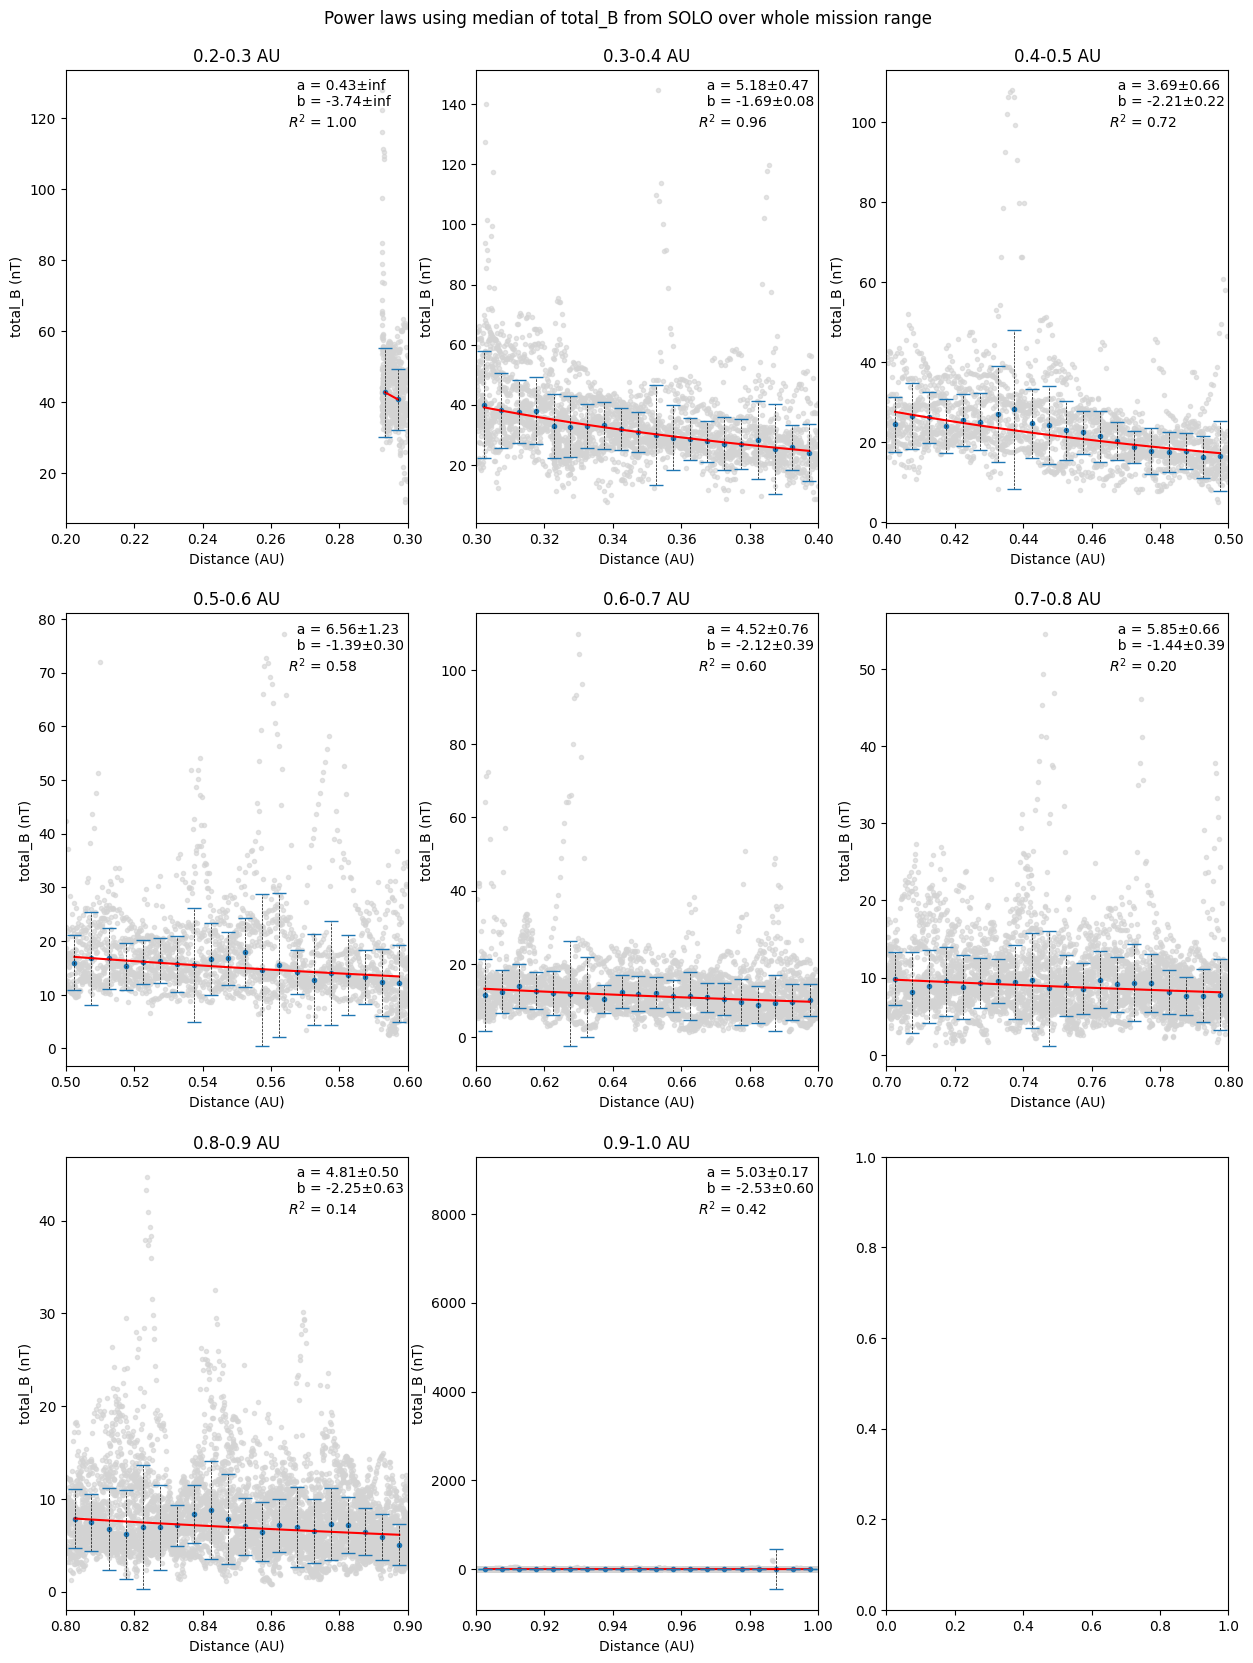

In [9]:
fig, ax, psp_fit = plot_power_laws('psp', 'total_B', 'nT', bins=10, subs=200)
fig, ax, solo_fit = plot_power_laws('solo', 'total_B', 'nT', bins=10, subs=200)

# Individual Power Law

In [10]:
def plot_power_law(sc_name, param, unit=None, year=None, years=None, bins=20, log=True, Vp=None, dist_lim=(0.2, 0.8)):
    # Select 0.2 to 0.8 AU
    sc = create_ds(sc_name, year, years, dist_lim)
    
    if Vp:
        sc = sc[(sc['Vp'] >= Vp)]
    
    # Take absolute value for B_r / B_t / B_n
    if param in ['B_r', 'B_t', 'B_n']:
        sc[f'{param}'] = sc[f'{param}'].abs()

    # Calculate medians and standard deviations
    sc_dist_med, sc_dist_std = bin_distance(sc, bins)

    # Remove Nans
    data = pd.concat([sc_dist_med['Distance'], sc_dist_med[f'{param}'], sc_dist_std[f'{param}']], axis=1).dropna()
    x_clean = data.iloc[:, 0].values
    y_clean = data.iloc[:, 1].values
    s_clean = data.iloc[:, 2].values

    # Fit curve
    p_fit_global, e_fit_global, r_squared_global, chi2_val, _ = fit_model(power_law, x_clean, y_clean, s=s_clean)

    # Plot radial relationship
    fig, ax = plt.subplots(figsize=(10,6), dpi=150)
    ax.plot(sc['Distance'], sc[f'{param}'], '.', alpha=.6, color='lightgrey')
    ax.plot(sc_dist_med['distance_bin'].apply(lambda x: x.mid), sc_dist_med[f'{param}'], '.')
    # Plot errorbars
    ax.errorbar(sc_dist_med['distance_bin'].apply(lambda x: x.mid), sc_dist_med[f'{param}'], yerr=sc_dist_std[f'{param}'], fmt='none', ecolor='k')

    # Plot fit and r^-2
    ax.plot(sc['Distance'].sort_values(), power_law(sc['Distance'].sort_values(), *p_fit_global), 'r-', label='Power law fit')
    if param in ['B_r', 'total_B', 'Np']:
        ax.plot(sc['Distance'].sort_values(), 1/sc['Distance'].sort_values()**2, label='$r^{-2}$')
   

    # Labels and limits
    ax.set_xlabel('Distance (AU)')
    ax.set_ylabel(f'{param} ({unit})')
    ax.set_xlim(dist_lim)

    if log:
        ax.set_yscale('log')

    # Add fit parameters
    ax.text(0.65, 0.98, f'{'a':>3} = {p_fit_global[0]:.2f}±{e_fit_global[0]:.2f}\n{'b':>3} = {p_fit_global[1]:.2f}±{e_fit_global[1]:.2f}\n$R^2$ = {r_squared_global:.2f}', ha='left', va='top', transform=ax.transAxes)

    # Title
    if years:
        fig.suptitle(f'Median {param} vs Distance, {sc_name.upper()} data, bins={bins} between {years[0]}-{years[1]}', y=.92)

    else:
        fig.suptitle(f'Median {param} vs Distance, {sc_name.upper()} data, bins={bins}', y=.92)


    # Legend
    ax.legend()

    return fig, ax, p_fit_global, e_fit_global, r_squared_global, chi2_val

(<Figure size 1500x900 with 1 Axes>,
 <Axes: xlabel='Distance (AU)', ylabel='total_B (nT)'>,
 array([ 5.60668978, -1.63628273]),
 array([0.1743486 , 0.03741085]),
 np.float64(0.9826529681487834),
 np.float64(1.7080048424500118))

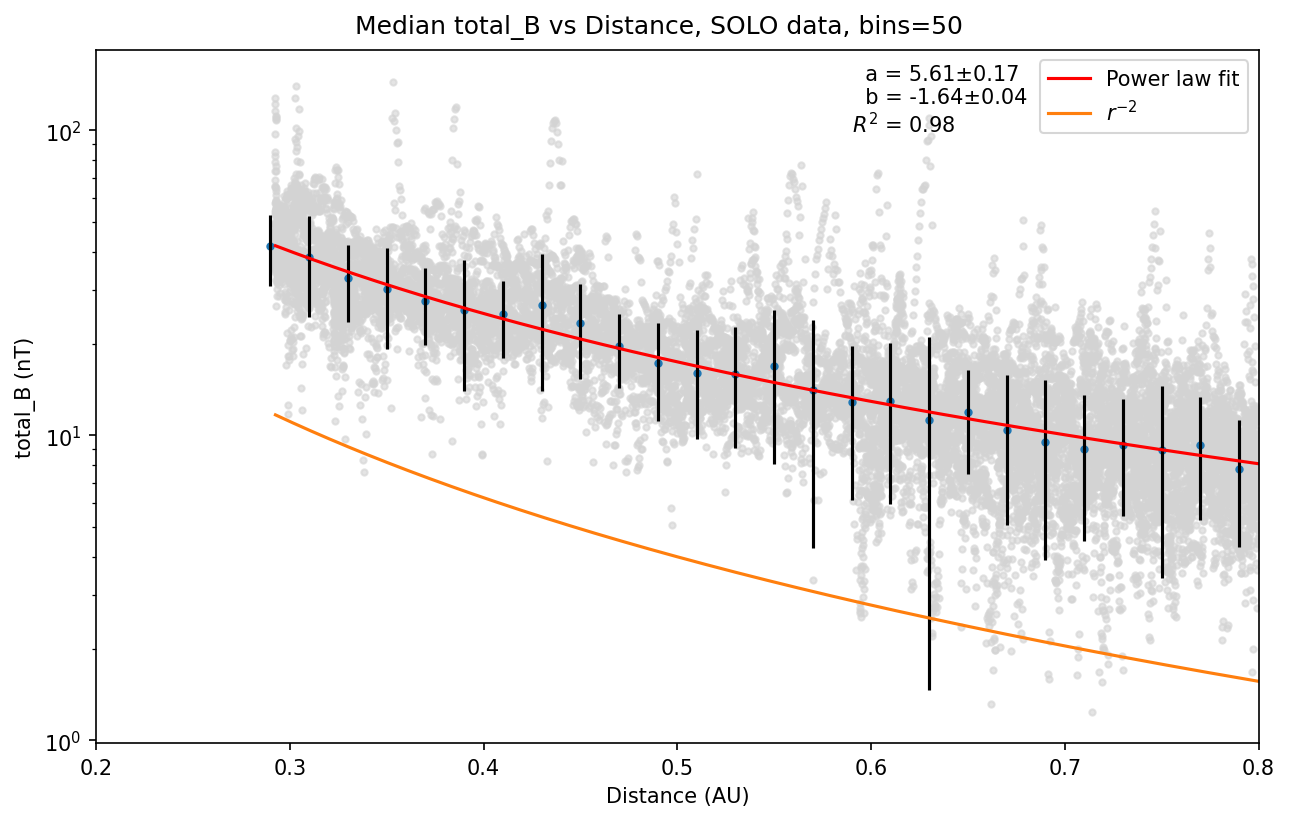

In [26]:
plot_power_law('solo', 'total_B', 'nT', dist_lim=(0.2, 0.8), bins=50)

(15313, 55767)

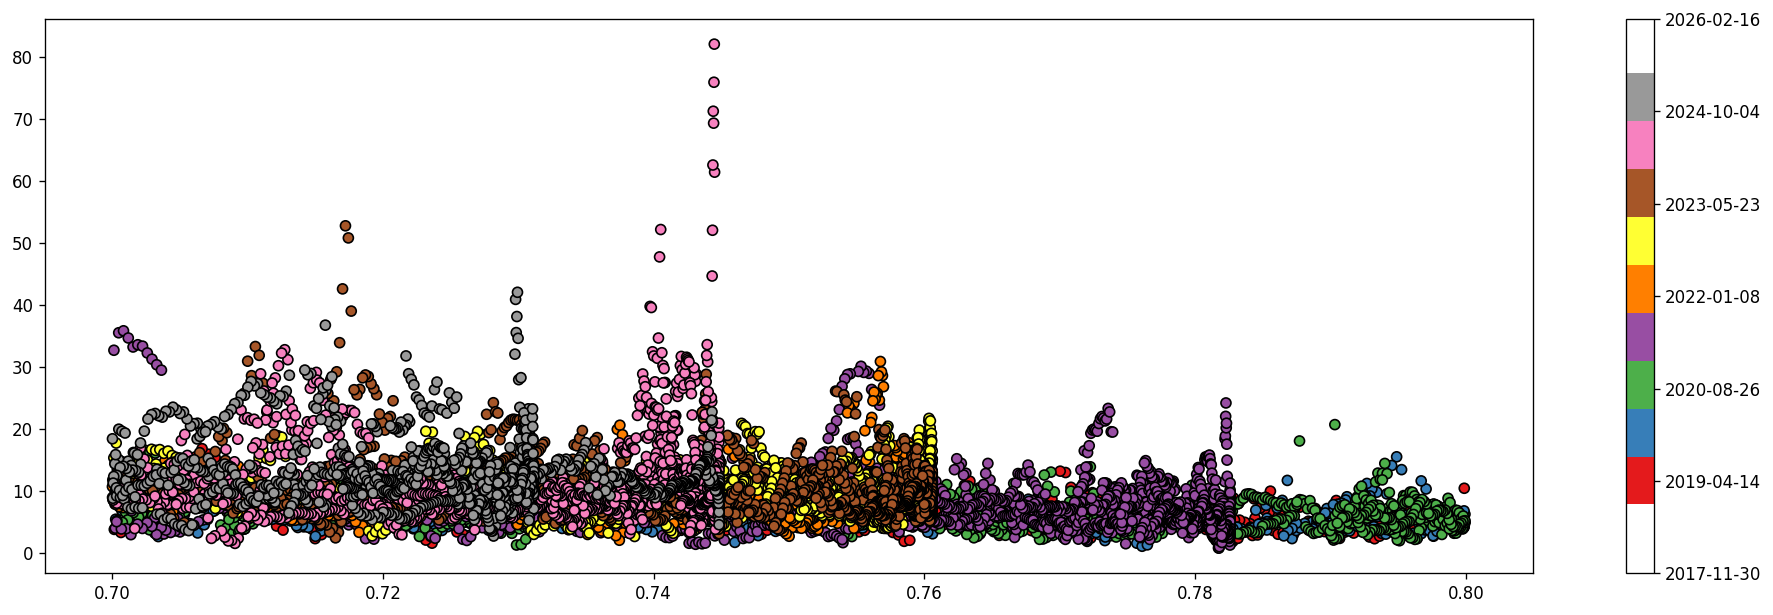

In [12]:
sc_name = 'psp'
sc = create_ds(sc_name, dist_lim=(.7, .8))

# Create figure
fig, ax = plt.subplots(figsize=(20, 6), dpi=120)

# Time into floats
time_float = mdates.date2num(sc.index)

# Plot
scatter = ax.scatter(sc['Distance'], sc['total_B'], c=time_float, cmap='Set1', edgecolor='k')
cbar = plt.colorbar(scatter)

# Replace colorbar ticks with dates
tick_locs = cbar.get_ticks()
tick_labels = [mdates.num2date(t).strftime('%Y-%m-%d') for t in tick_locs]
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)

len(sc), len(create_ds(sc_name))

In [13]:
for sc_name in ['solo', 'psp']:
    print(sc_name.upper())
    for i in np.arange(0, 1, 0.1):
        dist_lim = (round(i, 1), round(i+.1, 1))
        sc = create_ds(sc_name, dist_lim=dist_lim)
        print(f'{dist_lim[0]}-{dist_lim[1]} AU, stdev: {sc['total_B'].std():.2f}')

SOLO
0.0-0.1 AU, stdev: nan
0.1-0.2 AU, stdev: nan
0.2-0.3 AU, stdev: 10.96
0.3-0.4 AU, stdev: 12.21
0.4-0.5 AU, stdev: 9.19
0.5-0.6 AU, stdev: 7.86
0.6-0.7 AU, stdev: 6.83
0.7-0.8 AU, stdev: 4.38
0.8-0.9 AU, stdev: 3.89
0.9-1.0 AU, stdev: 88.00
PSP
0.0-0.1 AU, stdev: 309.85
0.1-0.2 AU, stdev: 63.72
0.2-0.3 AU, stdev: 21.33
0.3-0.4 AU, stdev: 9.38
0.4-0.5 AU, stdev: 6.92
0.5-0.6 AU, stdev: 6.06
0.6-0.7 AU, stdev: 4.84
0.7-0.8 AU, stdev: 5.02
0.8-0.9 AU, stdev: 2.66
0.9-1.0 AU, stdev: 1.75


Combined maps

ValueError: too many values to unpack (expected 5)

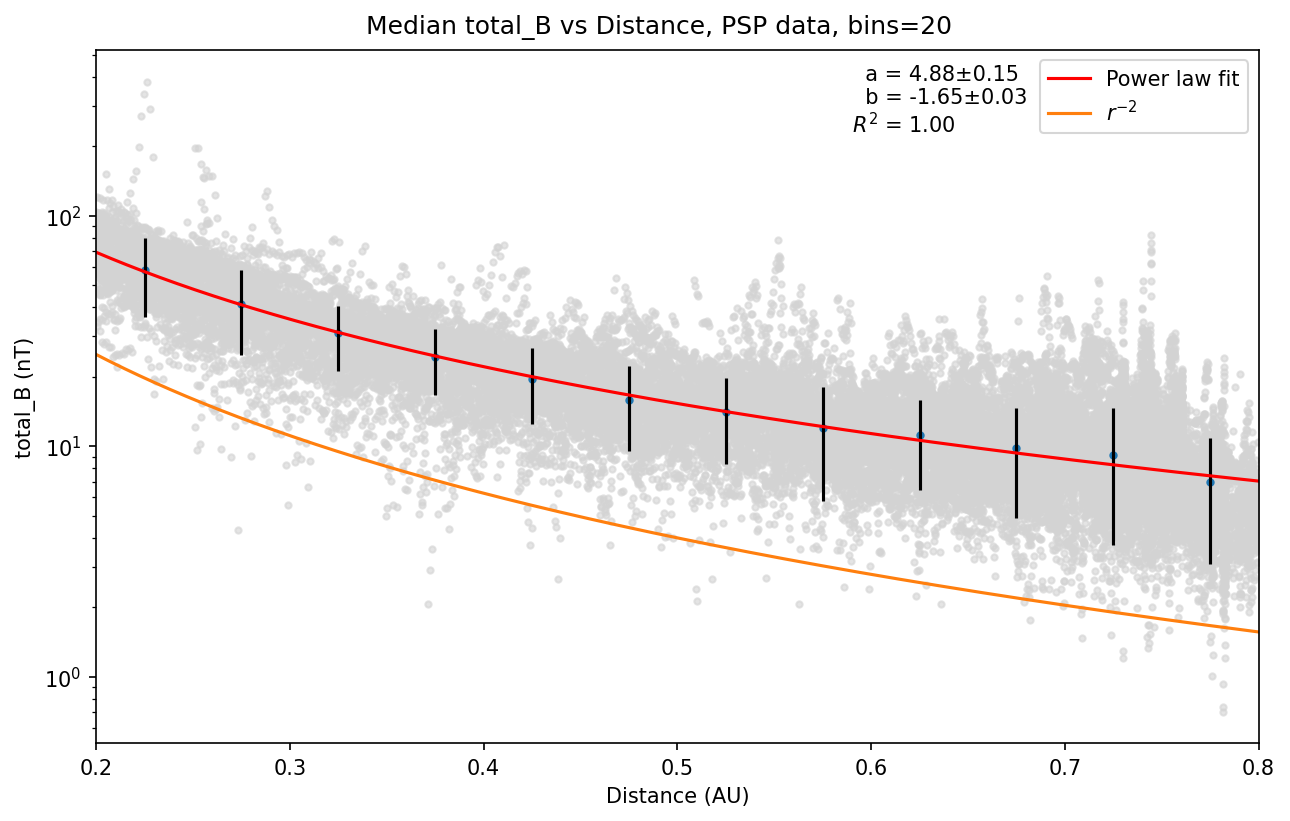

In [14]:
# Create dataset
sc_name = 'psp'
sc = create_ds(sc_name)

# Get the fit parameters
_, _, p_fit_far, _, _ = plot_power_law(sc_name, 'total_B', 'nT', log=True)
_, _, p_fit_close, _, _ = plot_power_law(sc_name, 'total_B', 'nT', log=True, dist_lim=(0, .2))

sc_distance = np.linspace(sc['Distance'].min(), 0.8, 1000)

# Calculate fits
fit_far = power_law(sc_distance, *p_fit_far)
fit_close = power_law(sc_distance, *p_fit_close)

# Find inflection point
inflection_point = sc_distance[np.absolute(fit_close - fit_far).argmin()]

# Create Figure
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Calculate medians and errors
sc_dist_med, sc_dist_std = bin_distance(sc, counts=20)

# Plot all the data points
ax.plot(sc['Distance'], sc['total_B'], '.', alpha=.6, color='lightgrey')

# Plot Medians
ax.plot(sc_dist_med['distance_bin'].apply(lambda x: x.mid), sc_dist_med['total_B'], '.')
# Plot errorbars
ax.errorbar(sc_dist_med['distance_bin'].apply(lambda x: x.mid), sc_dist_med['total_B'], yerr=sc_dist_std['total_B'], fmt='none', ecolor='k')

# Plot the fits
ax.plot(sc_distance, fit_far, '-', color='tab:purple',label='$r^{-1.65}$')
ax.plot(sc_distance, fit_close, '-', color='tab:green', label='$r^{-2.21}$')
ax.plot(sc_distance, 1/sc_distance**2, 'r-', label='$r^{-2}$')

# Plot the inflection point
ax.axvline(inflection_point, linestyle='--', color='k', alpha=.5)

# Scale, limits, labels
ax.set_yscale('log')
ax.set_xlim(0, 0.8)
ax.set_xlabel('Distance (AU)')
ax.set_ylabel(f'total B (nT)')

# Legend and title
ax.legend()
fig.suptitle(f'Total B-field and different fits for {sc_name.upper()} between 0 and 0.8 AU over entire mission', y=.91)

PSP
B_r [nT]: 3.53±0.39 | -1.71±0.11, | 0.78
B_t [nT]: 2.02±0.34 | -1.67±0.18, | 0.86
total_B [nT]: 5.23±0.28 | -1.86±0.06, | 0.87
Np [1/cm3]: 2.86±0.74 | -1.99±0.32, | 0.61
Tp [eV]: 4.66±1.96 | -1.05±0.39, | 0.46
SOLO
B_r [nT]: 3.53±0.29 | -1.92±0.09, | 0.97
B_t [nT]: 3.37±0.68 | -0.86±0.25, | 0.37
total_B [nT]: 7.37±0.65 | -1.47±0.09, | 0.94
Np [1/cm3]: 4.44±0.72 | -1.79±0.17, | 0.61
Tp [eV]: 22.97±1.89 | -0.66±0.09, | 0.81


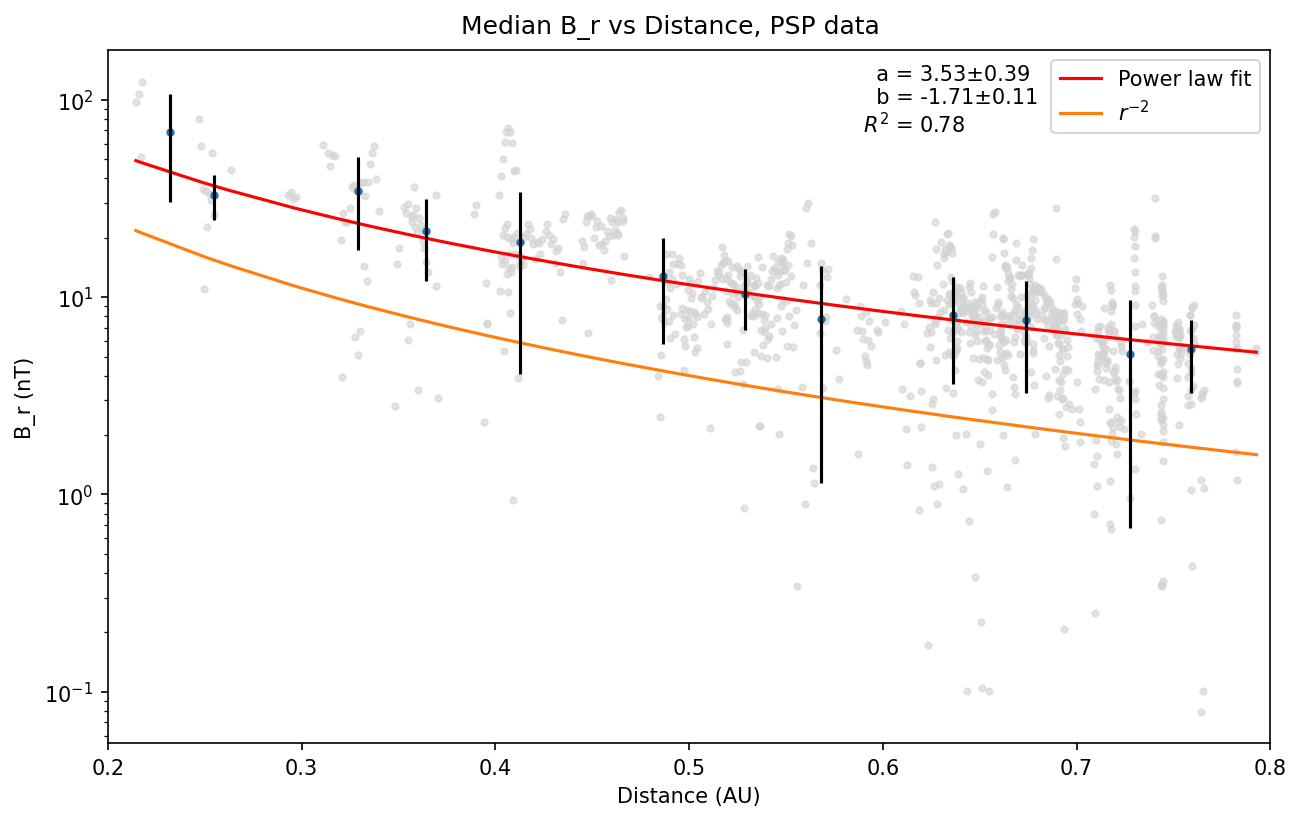

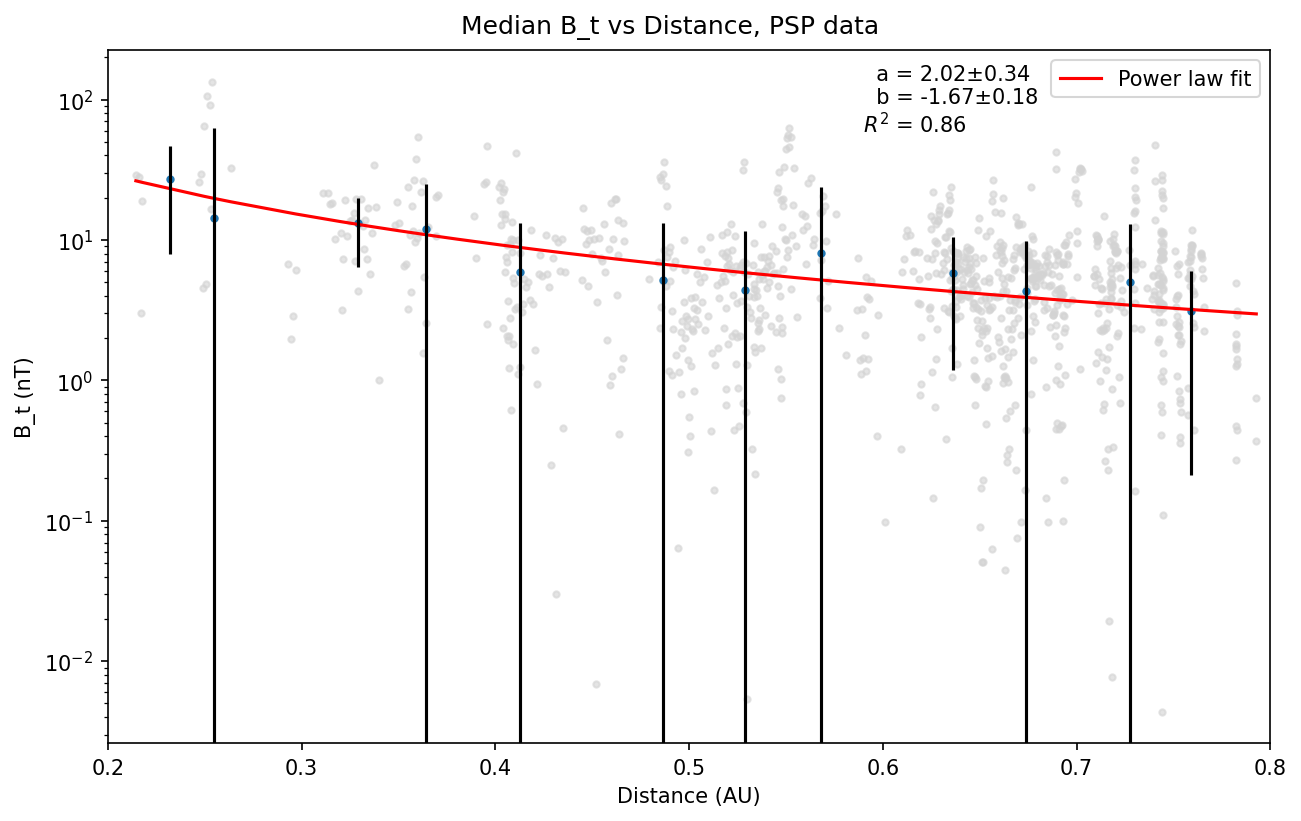

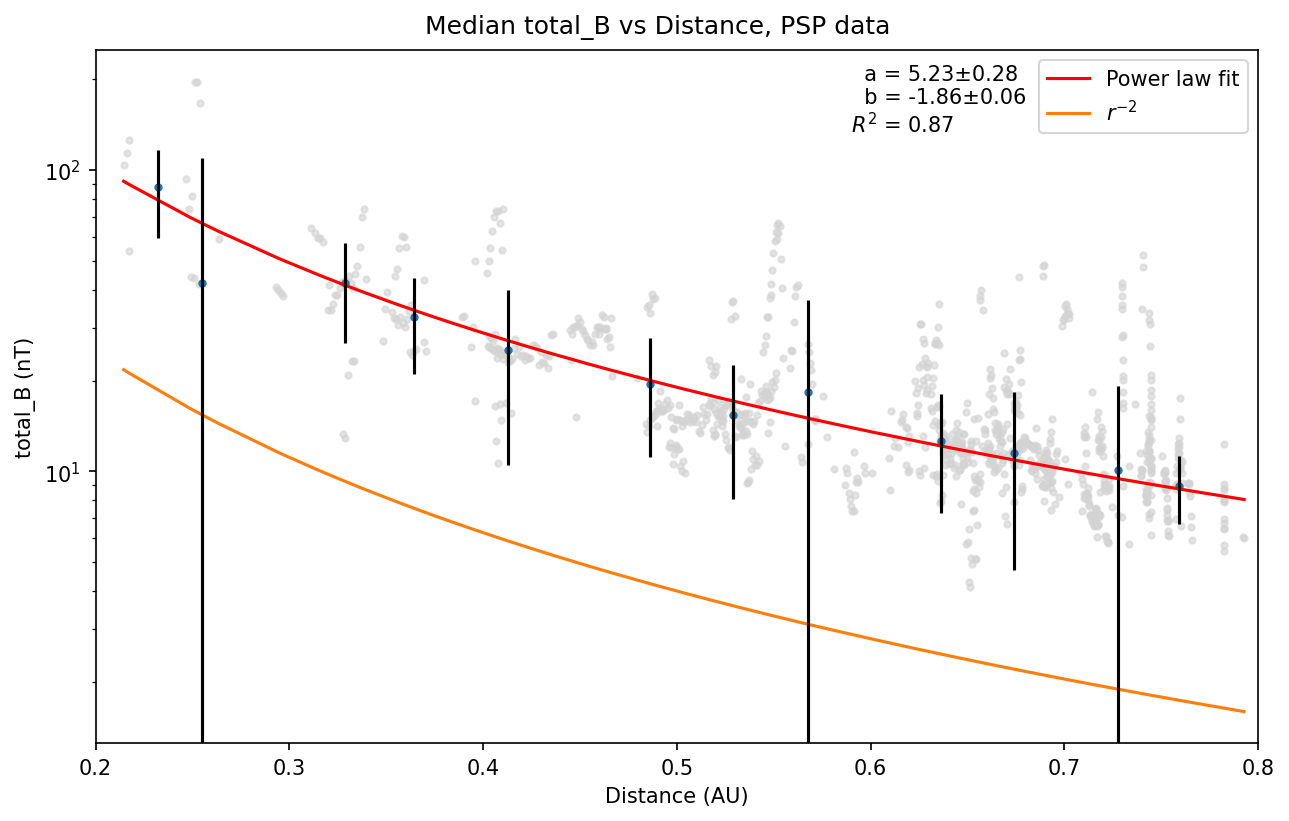

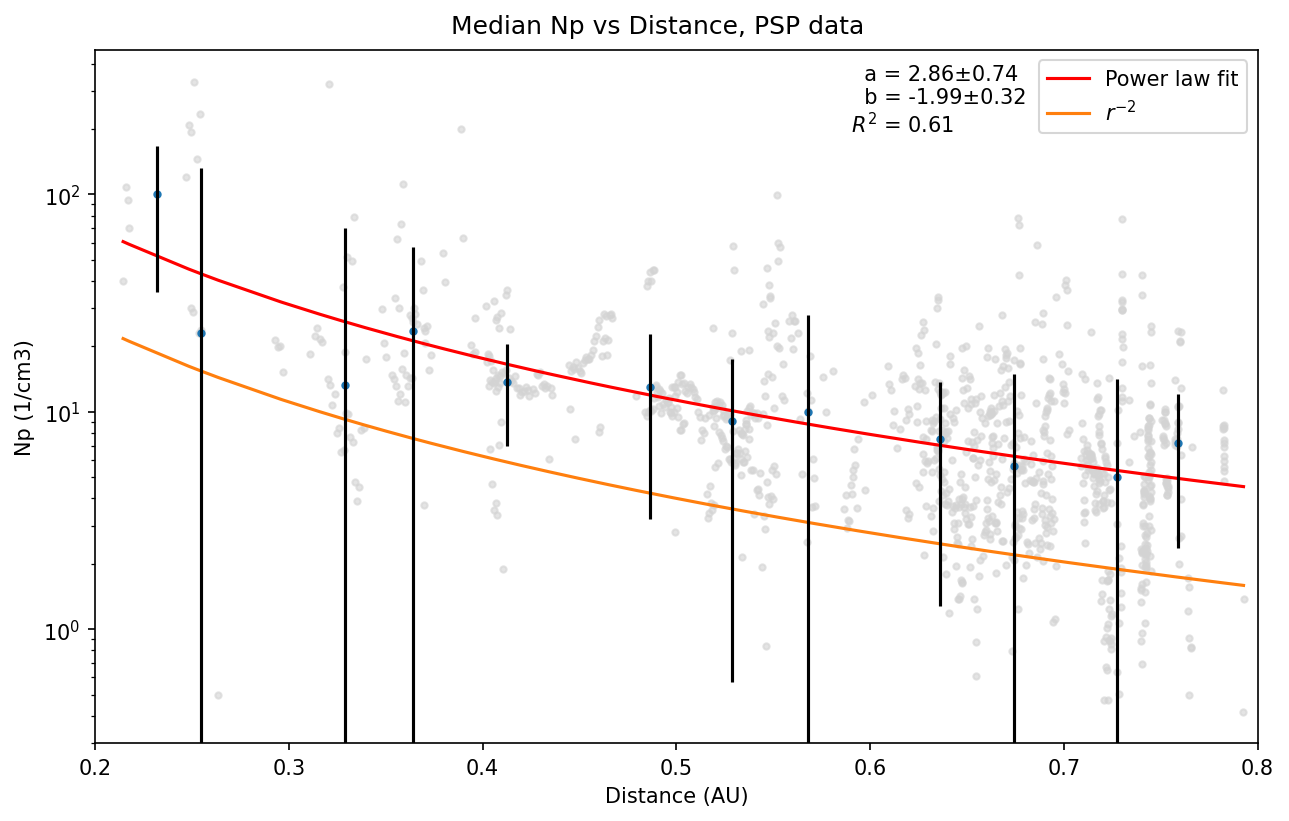

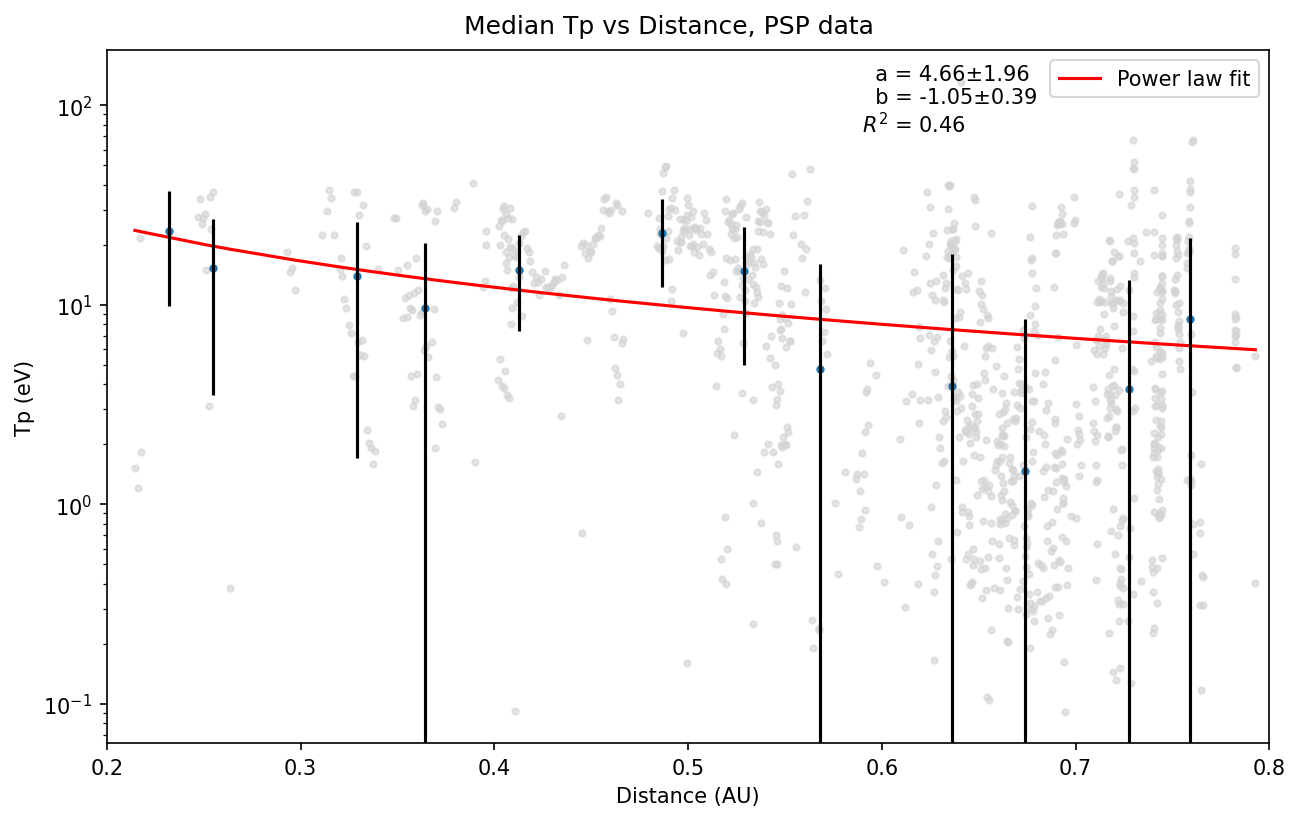

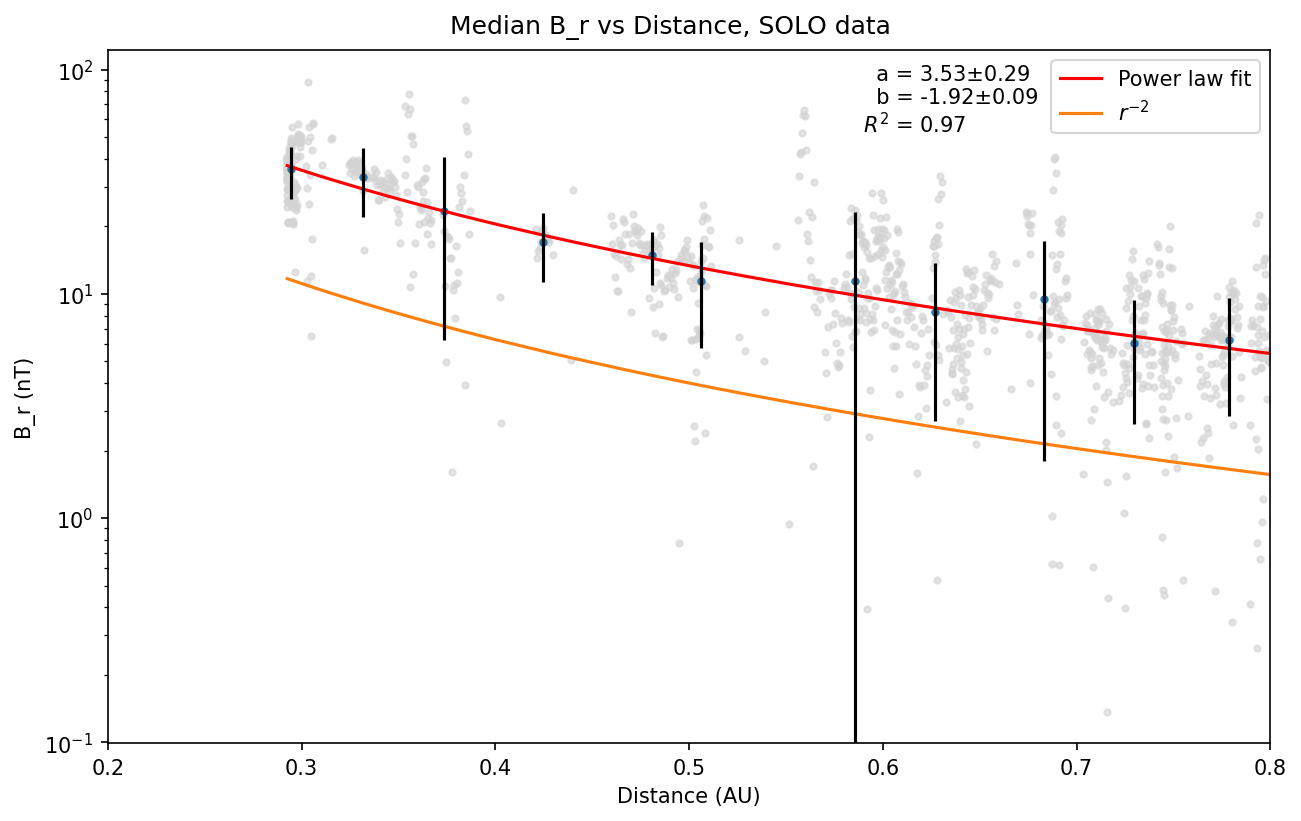

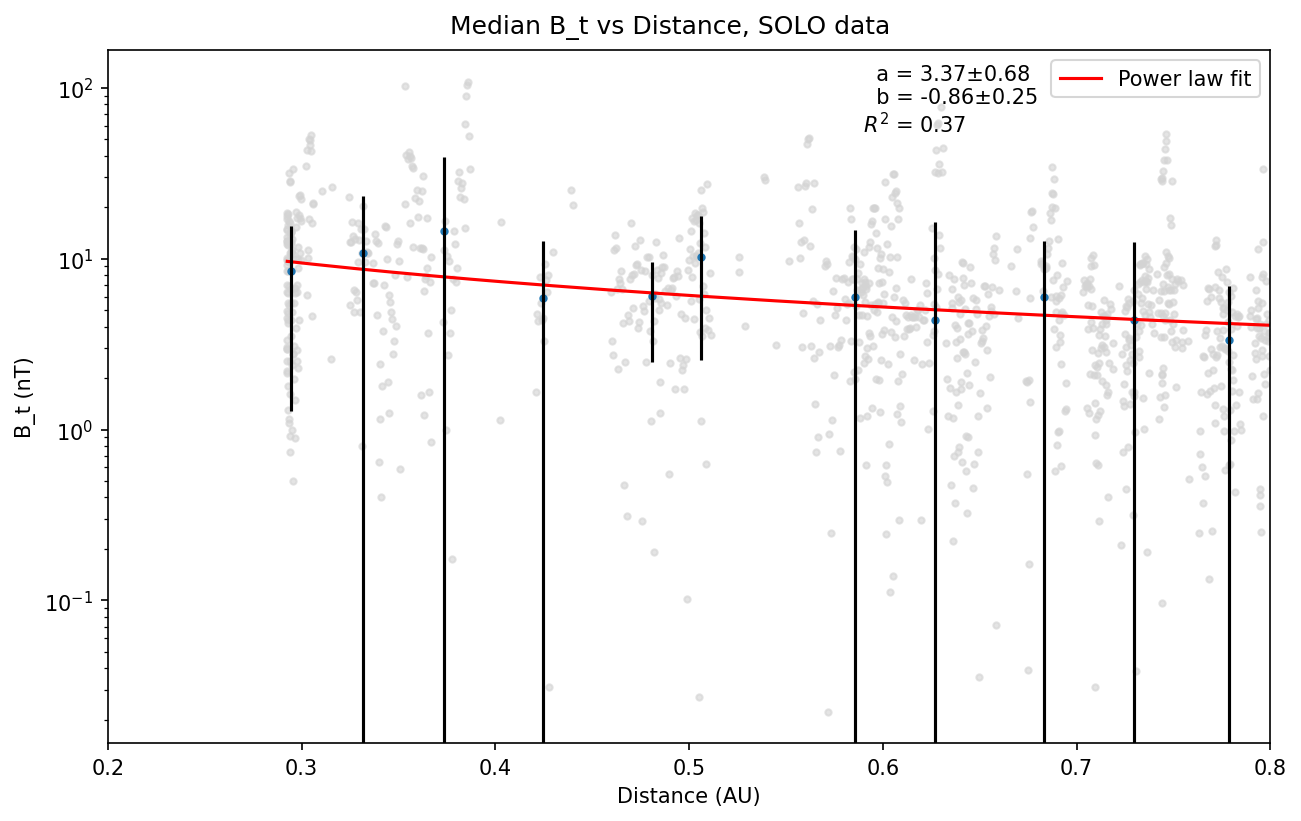

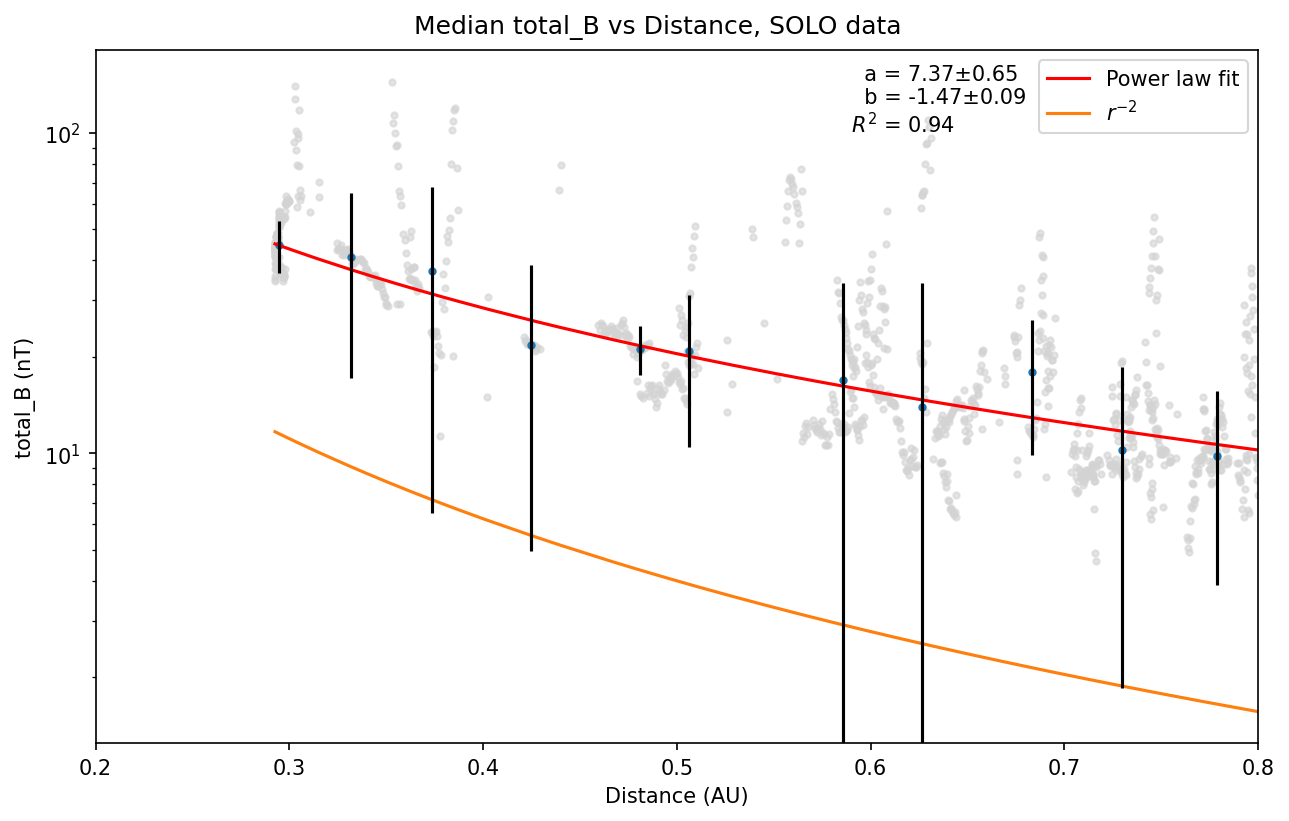

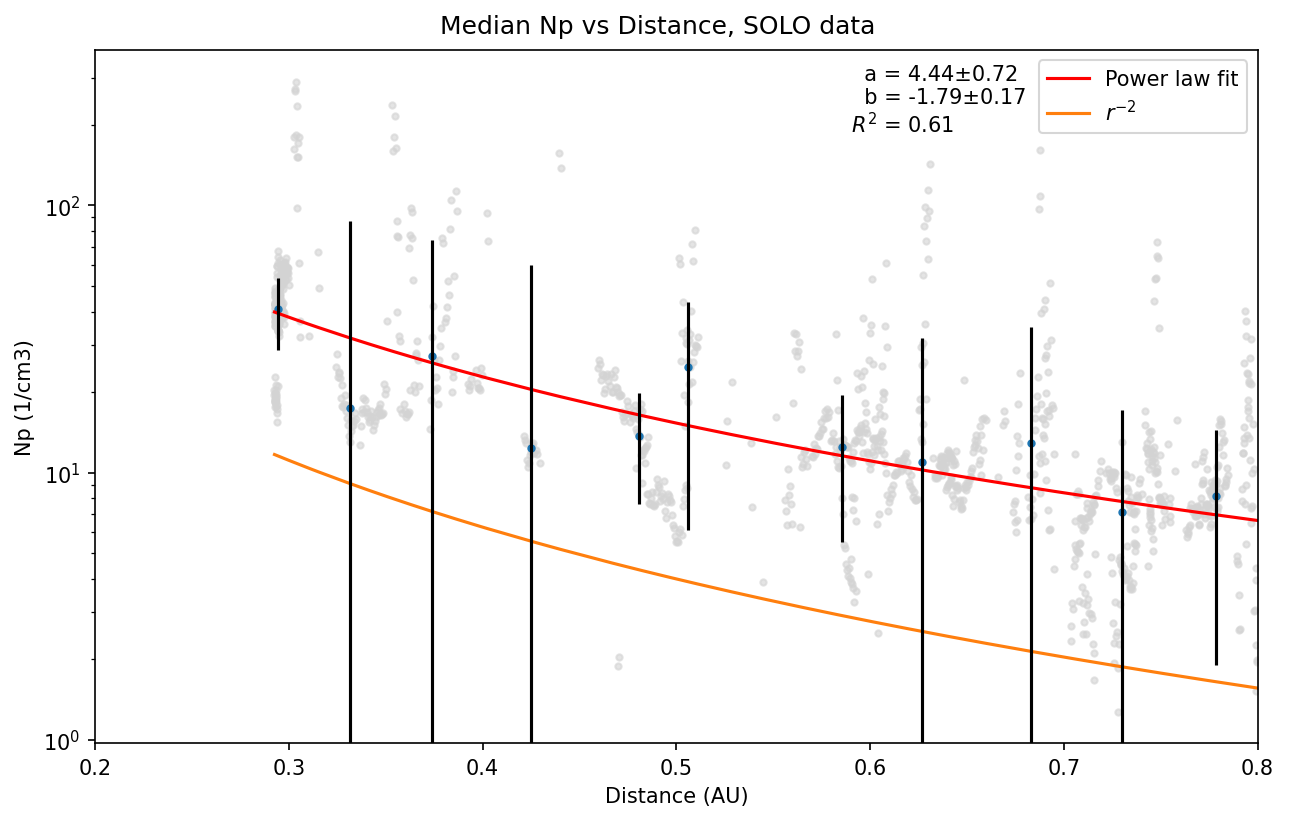

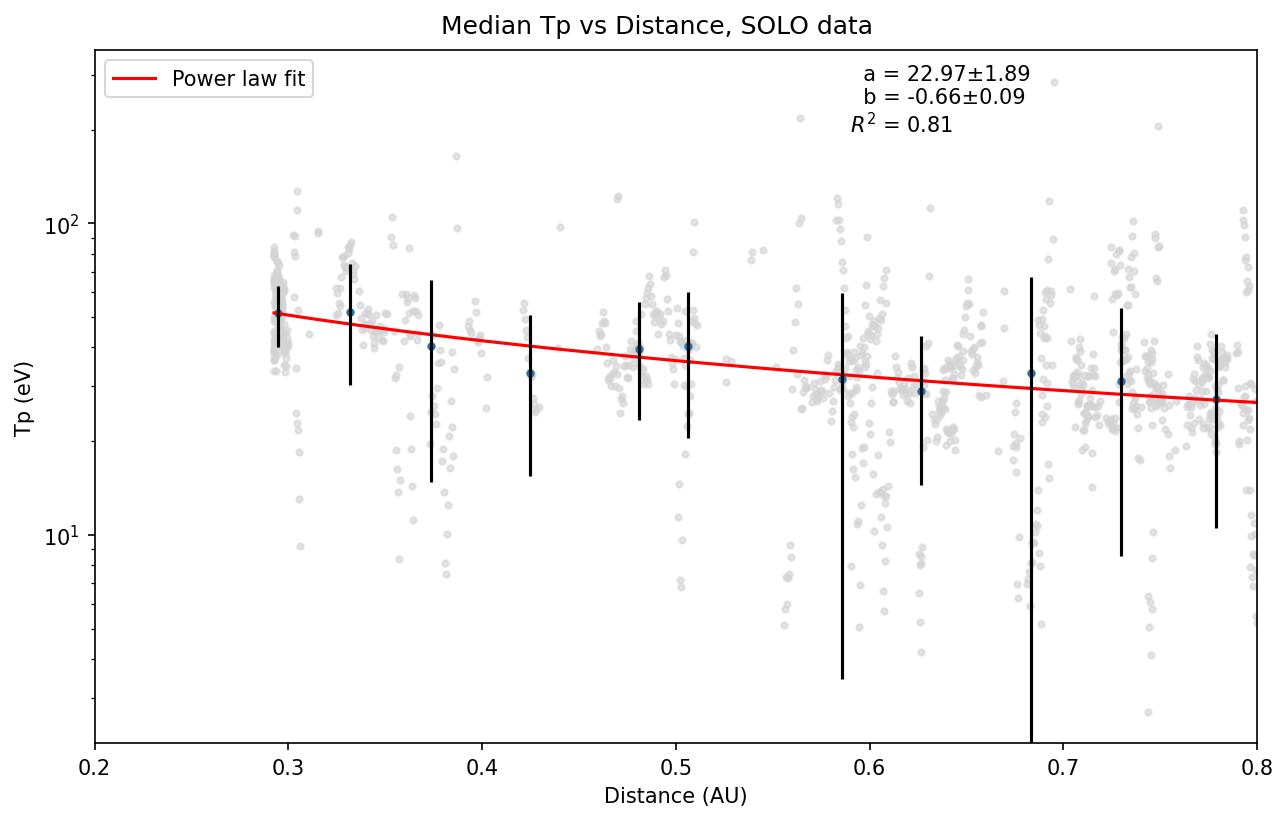

In [ ]:
for sc_name in ['psp', 'solo']:
    print(sc_name.upper())
    for param, unit in [('B_r', 'nT'), ('B_t', 'nT'), ('total_B', 'nT'), ('Np', '1/cm3'), ('Tp', 'eV')]:

        _, _, p_fit, e_fit, r_squared = plot_power_law(sc_name, param, unit, Vp=600)
        print(f'{param} [{unit}]: {p_fit[0]:.2f}±{e_fit[0]:.2f} | {p_fit[1]:.2f}±{e_fit[1]:.2f}, | {r_squared:.2f}')

NameError: name 'p_fit_global' is not defined

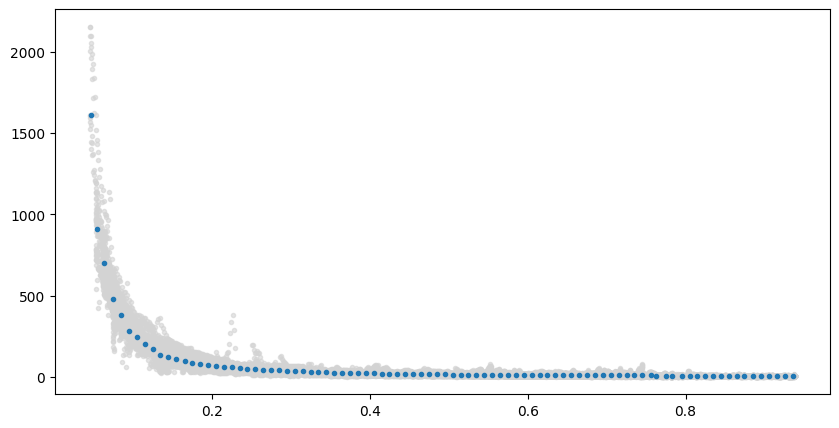

In [ ]:
psp = create_ds('psp')

psp_dist_med, psp_dist_std = bin_distance(psp, 100)

fig, ax = plt.subplots(figsize=(10,5))

# Remove Nans
data = pd.concat([psp_dist_med['Distance'], psp_dist_med['total_B'], psp_dist_std['total_B']], axis=1).dropna()
x_clean = data.iloc[:, 0].values
y_clean = data.iloc[:, 1].values
s_clean = data.iloc[:, 2].values

# Fit
p_fit, e_fit, r_squared, _ = fit_model(power_law, x_clean, y_clean, s=s_clean)

ax.plot(psp['Distance'], psp['total_B'], '.', alpha=.6, color='lightgrey')
ax.plot(psp_dist_med['Distance'], psp_dist_med['total_B'], '.')
ax.plot(psp['Distance'], power_law(psp['Distance'], *p_fit_global), 'r-', label='Power law fit 0.3-0.8 AU')
ax.plot(psp['Distance'], power_law(psp['Distance'], *p_fit), 'g-', label='Power law fit 0.0-1.0 AU')

ax.errorbar(psp_dist_med['Distance'], psp_dist_med['total_B'], yerr=psp_dist_std['total_B'], fmt='none', ecolor='k')

ax.set_xlabel('Distance (AU)')
ax.set_ylabel('Total $B$ (nT)')
ax.legend()
#ax.set_ylim(0, 100)

#ax.text(0.65, 0.98, f'{'a':>3} = {p_fit[0]:.2f}±{e_fit[0]:.2f}\n{'b':>3} = {p_fit[1]:.2f}±{e_fit[1]:.2f}\n$R^2$ = {r_squared:.2f}', ha='left', va='top', transform=ax.transAxes)

fig.suptitle(f'Median Magnetic field vs Distance, entire {sc.upper()} mission range', y=.92)

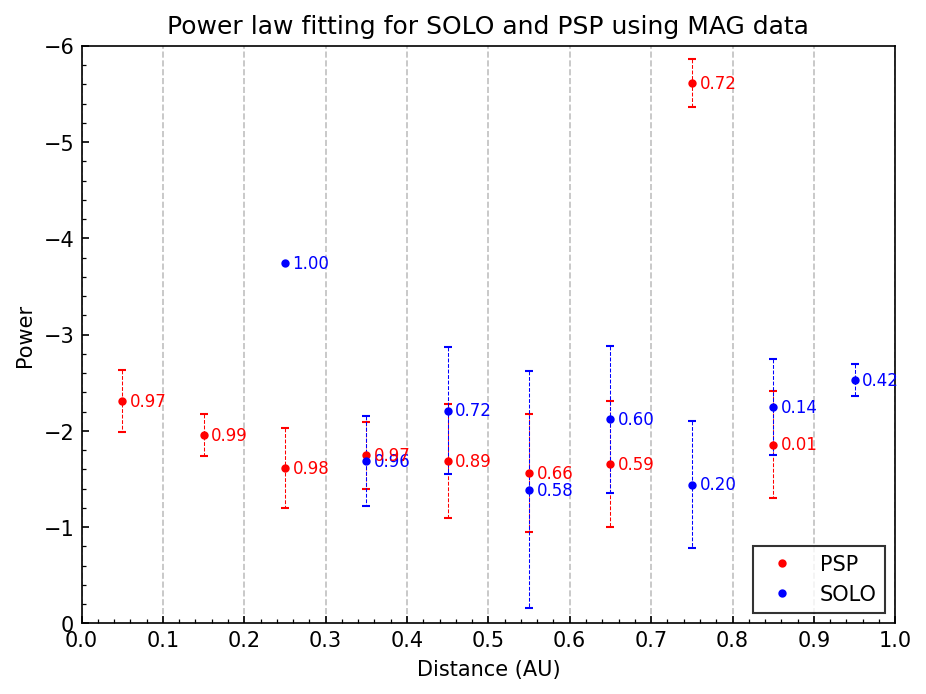

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

c_solo = 'blue'
c_psp = 'red'

# psp errorbar
err_psp = ax.errorbar(psp_fit['bin_start']+.05, psp_fit['b'], yerr=psp_fit['a_e'], fmt='none', capsize=2, ecolor=c_psp)

for barlinecol in err_psp[2]:
    barlinecol.set_linestyle('--')
    barlinecol.set_linewidth(0.5)
    barlinecol.set_color(c_psp)

# solo errorbar
err_solo = ax.errorbar(solo_fit['bin_start']+.05, solo_fit['b'], yerr=solo_fit['a_e'], fmt='none', capsize=2, ecolor=c_solo)

for barlinecol in err_solo[2]:
    barlinecol.set_linestyle('--')
    barlinecol.set_linewidth(0.5)
    barlinecol.set_color(c_solo)

# Plot powers
ax.plot(psp_fit['bin_start']+.05, psp_fit['b'], '.', c=c_psp, label='PSP')
ax.plot(solo_fit['bin_start']+.05, solo_fit['b'], '.', c=c_solo, label='SOLO')

# Add r_squared information
for x, y, label in zip(solo_fit['bin_start']+.05, solo_fit['b'], solo_fit['r_squared']):
    ax.annotate(
        text=f'{label:.2f}',
        xy=(x, y),
        textcoords="offset points",
        xytext=(12.5, -2.5),
        ha='center',
        fontsize=8,
        color=c_solo
    )

for x, y, label in zip(psp_fit['bin_start']+.05, psp_fit['b'], psp_fit['r_squared']):
    ax.annotate(
        text=f'{label:.2f}',
        xy=(x, y),
        textcoords="offset points",
        xytext=(12.5, -2.5),
        ha='center',
        fontsize=8,
        color=c_psp
    )

# Set xy labels
ax.set_xlabel('Distance (AU)')
ax.set_ylabel('Power')

# Set xlim, ylim
ax.set_xlim(0, 1)
ax.set_ylim(0, -6)

# Set ticks
major_ticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(major_ticks)

ax.minorticks_on()
ax.tick_params(which='both', direction='in')

# Set Legend, grid
ax.grid(ls='--', alpha=.8, which='major', axis='x')
ax.legend(loc='lower right', fancybox=False, edgecolor='k')

# Set title
ax.set_title('Power law fitting for SOLO and PSP using MAG data');